(skew_coords_solution)=
# Week2: Theromodynamic diagrams worksheet -- solution



## The University of Wyoming Upperair archive



The University of Wyoming maintains a public archive of balloon sounding data at [https://weather.uwyo.edu/upperair/sounding.html](https://weather.uwyo.edu/upperair/sounding.html)

This data can be accessed using the Python [requests module](https://realpython.com/python-requests/)

The Wyoming web server responds to a "get request" of the form:

     https://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2024&MONTH=01&FROM=1912&TO=1912&STNM=71957

Where:

- region is one of naconf, samer, pac, nz, ant, np, europe,africa, seasia, mideast
- year and month are in the format yyyy and mm respectively
- from and to are days of month in dd inclusive
- stnm is the station number from this table:  [https://www.nws.noaa.gov/dm-cgi-bin/nsd_state_lookup.pl](https://www.nws.noaa.gov/dm-cgi-bin/nsd_state_lookup.pl)

## The wyominglib sounding module

### Fetching soundings

The [a500.soundings.wyominglib.write_soundings function](https://phaustin.github.io/a405_lib/_modules/a405/soundings/wyominglib.html#write_soundings) takes a dictionary with these
parameters and a path to a folder, makes the requests to the Wyoming site and writes soundings in csv format to the folder

#### write_sound example

Get all the February,2013 soundings for [Alta Floresta airport](https://www.google.com/maps/place/Alta+Floresta+Airport/@-9.8722629,-56.1049062,15z/data=!4m6!3m5!1s0x93aa317851e54e4f:0x2c2df4288fa7837e!8m2!3d-9.8722629!4d-56.1049062!16s%2Fm%2F04fnn0d?entry=ttu) in Brazil and save to a folder called brazil_soundings

In [3]:
from a500.soundings.wyominglib import write_soundings
write = False
if write:
    values=dict(region='samer',year='2013',month='2',start='0100',stop='2800',station='82965')
    sounding_dir = 'brazil_soundings'
    write_soundings(values, sounding_dir)

### reading soundings into pandas dataframes

The function [a500.soundings.wyominglib.read_soundings](https://phaustin.github.io/a405_lib/_modules/a405/soundings/wyominglib.html#read_soundings) takes a string with the directory name and reads all of the csv files into pandas dataframes.

#### read_soundings example

This cell shows how to get the pandas dataframe for the airport sounding on Feb. 1, 2013 at 12 UCT

In [4]:
from a500.soundings.wyominglib import read_soundings
sounding_dir = 'brazil_soundings'
brazil_dict = read_soundings(sounding_dir)

dict_keys = list(brazil_dict.keys())
print(f"{dict_keys=}")
print(f"{brazil_dict['attributes']=}")
sounding_dict = brazil_dict['sounding_dict']
soundings = list(sounding_dict.keys())
print(f"{soundings=}") 
the_sound = sounding_dict[(2013,2,1,12)]
print(f"{the_sound=}")

dict_keys=['filelist', 'attributes', 'input_args', 'file_dict', 'sounding_dict']
brazil_dict['attributes']={'units': 'hPa;m;C;C;%;g/kg;deg;knot;K;K;K', 'site_id': '82965', 'latitude': -9.86, 'longitude': -56.1, 'elevation': 2.0, 'header': '82965 SBAT Alta Floresta (Aero) Observations at 00Z 01 Feb 2013', 'history': 'written by test_requests.py'}
soundings=[(2013, 2, 1, 0), (2013, 2, 1, 12), (2013, 2, 2, 0), (2013, 2, 2, 12), (2013, 2, 3, 0), (2013, 2, 4, 0), (2013, 2, 4, 12), (2013, 2, 5, 0), (2013, 2, 5, 12), (2013, 2, 6, 0), (2013, 2, 6, 12), (2013, 2, 7, 0), (2013, 2, 7, 12), (2013, 2, 8, 0), (2013, 2, 8, 12), (2013, 2, 9, 0), (2013, 2, 9, 12), (2013, 2, 10, 0), (2013, 2, 10, 12), (2013, 2, 11, 0), (2013, 2, 11, 12), (2013, 2, 12, 0), (2013, 2, 12, 12), (2013, 2, 13, 0), (2013, 2, 13, 12), (2013, 2, 14, 0), (2013, 2, 14, 12), (2013, 2, 15, 0), (2013, 2, 15, 12), (2013, 2, 16, 0), (2013, 2, 16, 12), (2013, 2, 17, 0), (2013, 2, 17, 12), (2013, 2, 18, 0), (2013, 2, 18, 12), (2013, 2, 1

In [ ]:
press,temp = the_sound['pres'].to_numpy(), the_sound['temp'].to_numpy()
press, temp

## Making a Skew-T - ln P plot

Demonstrate how to construct dry adiabats and isotherms for
a thermodynamic diagram using the functions in
[a500.skewT.skewlib](https://phaustin.github.io/a405_lib/_modules/a405/skewT/skewlib.html#makeSkewDry)

The makeSkewDry function takes a matplotlib plotting axis and a skew paramter and returns a countour plot of the temperature and theta isolines to use for further plotting.

In the cells below we demonstrate how that works one line at a time

In [5]:
import numpy as np
from matplotlib import pyplot as plt

### 1. setting labels and ticks

The next box shows how to set up a plot of a 5 degree isotherm in
unskewed coordinates.   Note that I invert the yaxis so pressure increases
downwards, and I make y a log scale and draw a horizontal grid.

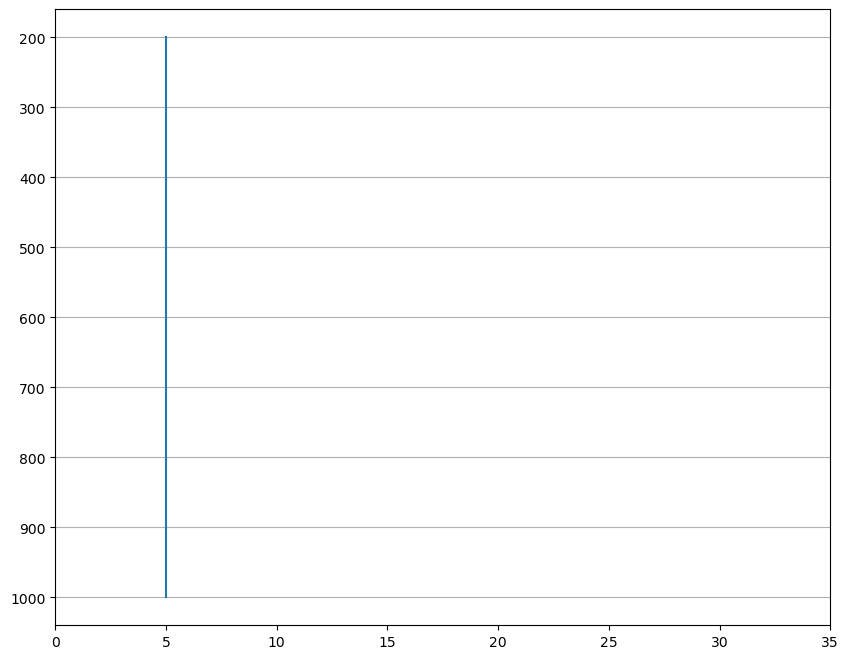

In [6]:
press=np.linspace(200,1000,30)
temps=np.ones_like(press)*5
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(temps,press)
ax.set(xlim=[0,35])
ax.invert_yaxis()
ax.yaxis.grid(True)

### 2. Calculating skewed temperature coordinates

If you try plotting your soundings on the conventional plot above, you'll see
that the height-temperature dependence makes it difficult to see the temperature
and dewpoint together.  The traditional approach is to slant the temperature
line by a constant slope (note that this is different from rotating the line,
because the y axis doesn't change)

In [7]:
#listing for a500.skewT.skewlib.convertSkewToTemp
def convertSkewToTemp(xcoord, press, skew):
    """
    convertSkewToTemp(xcoord, press, skew)

    Determines temperature from knowledge of a plotting coordinate
    system and corresponding plot skew.
    
    Parameters
    - - - - - -
    xcoord : int
        X coordinate in temperature plotting coordinates.
    press : float
        Pressure (hPa).
    skew : int
        Skew of a given coordinate system.

    Returns
    - - - -
    Temp : float
        Converted temperature in degC.

    Examples
    - - - - -
    >>> convertSkewToTemp(300, 8.e4, 30)
    638.6934574096806
    
    """
    Temp = xcoord  + skew * np.log(press);
    return Temp

#listing for a500.skewT.skewlib.convertTempToSkew
def convertTempToSkew(Temp, press, skew):
    """
    convertTempToSkew(Temp, press, skew)

    Determines the transformed temperature in plotting coordinates.
    
    Parameters
    - - - - - -
    Temp : float
        Temperature (degC)
    press : float
        Pressure (hPa).
    skew : int
        Designated skew factor of temperature.

    Returns
    - - - -
    tempOut : float
        Converted temperature (degC).

    Examples
    - - - - -
    >>> convertTempToSkew(30., 8.e4, 30)
    -308.69345740968055
    
    """
    
    tempOut = Temp - skew * np.log(press);
    return tempOut

### 3. Determining the skew

Getting a isotherm with a 45 degree slope in these coordinates is tricky, because it depends on
the shape of the plot and the exact range values chosen for the temperature and pressure axis.
Calculating the slope that will give a 45 degree angle isn't particularly hard (try it), but
it's easier to just try some different skew values, and then save the result so you can put
your data up in the same coordinates.  For square plots with typical sounding ranges setting
skew = 30 Kelvin  is about right.  Below I show what 4 different values of the skew look like.

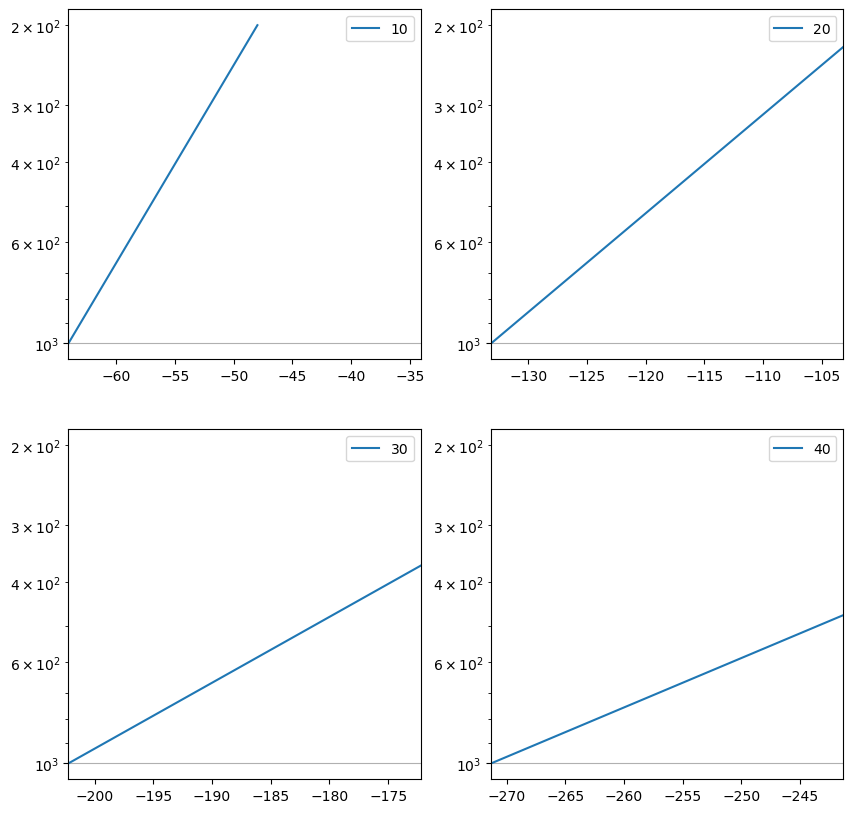

In [8]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
axes=axes.ravel()  #axes comes back as a 2x2 array, flatten it
press=np.linspace(200,1000,30)
the_temp=5.
linelist=[]
skew_vals=[10,20,30, 40]
for ax,skew in zip(axes,skew_vals):
    xcoord=convertTempToSkew(the_temp,press,skew)
    ax.plot(xcoord,press,label=skew)
    ax.invert_yaxis()
    ax.set_yscale('log')
    locs = np.array(range(100, 1100, 100))
    labels = locs
    ax.yaxis.grid(True)
    out=ax.legend()
    TempTickLabels = range(-15, 40, 5)
    TempTickCoords = TempTickLabels
    skewTickCoords = convertTempToSkew(TempTickCoords, 1.e3, skew)
    #ax.set_xticks(skewTickCoords)
    #out=ax.set_xticklabels(TempTickLabels)
    skewLimits = convertTempToSkew([5, 35], 1.e3, skew)
    out=ax.set(xlim=skewLimits)

### 4. using makeSkewDry

Here's a function that adds two contour grids in skewT coordinates

In [9]:
from a500.skewT.skewlib import makeSkewDry
help(makeSkewDry)

Help on function makeSkewDry in module a500.skewT.skewlib:

makeSkewDry(ax, skew=30)
    draw a skew-T lnP diagram on an axis
    
    Parameters
    ----------
    
    ax : matplotlib.axes
         matplotlib figure axis
    
    skew : float
    
           adjustable coefficient to make isotherms slope
           compared to adiabats
    
    Returns
    -------
    
    ax : matplotlib.axes
         the modified figure axis
    
    skew : float
           skew coefficient (K)



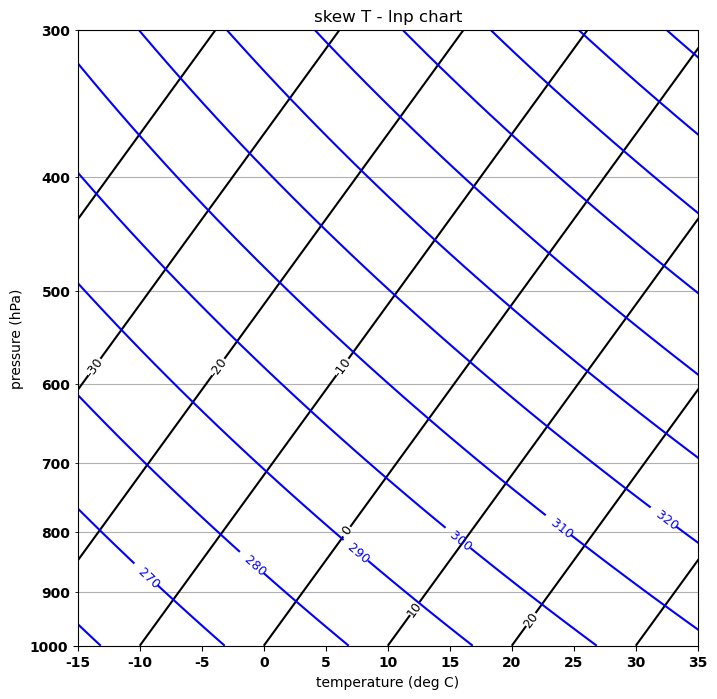

In [10]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)

### 5 Adding information to the plot

use the display finction to redraw the axis after you modify it

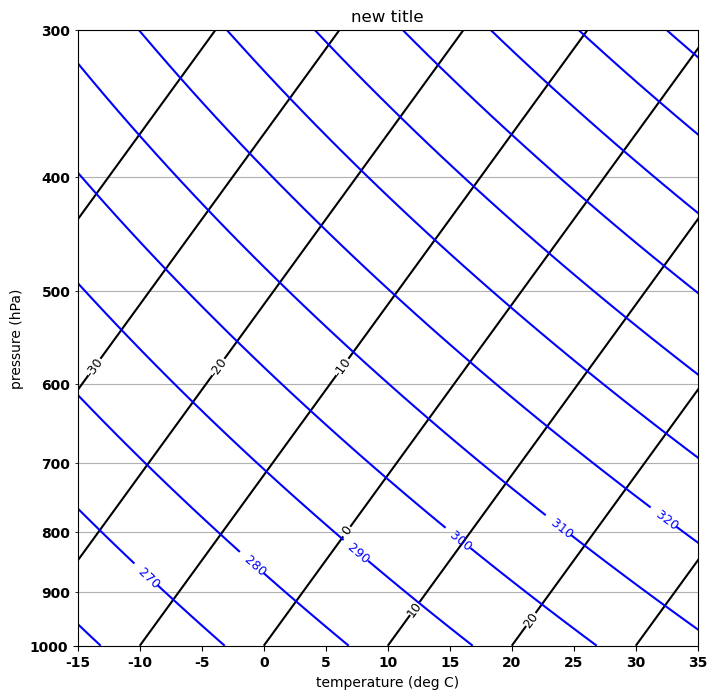

In [11]:
ax.set(title='new title')
display(fig)

###  6. Add a datapoint to the skewT diagram

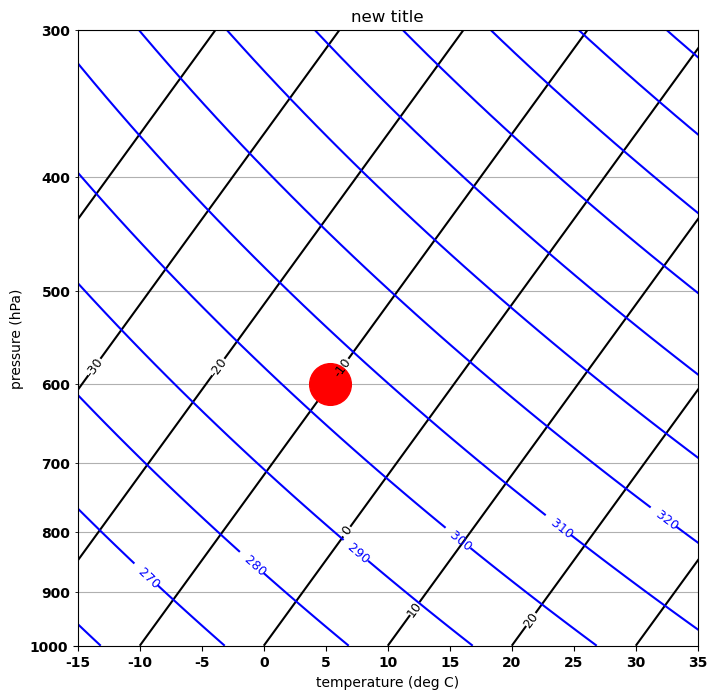

In [12]:
temp=-10
press=600
skewtemp=convertTempToSkew(temp,press,skew)
ax.plot(skewtemp,press,'ro',markersize=30)
display(fig)

### 7 change the axes

Here's how to change the xaxis so that the left corner at 1000 hPa goes down to -35 deg C
and the upper boundary stops at 600 hPa

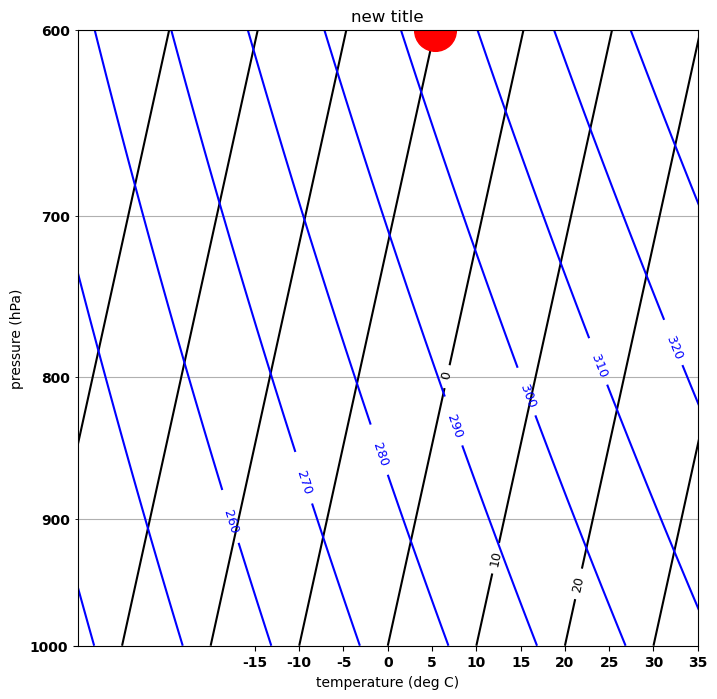

In [13]:
skewLimits = convertTempToSkew([-35, 35], 1.e3, skew)
out=ax.set(xlim=skewLimits,ylim=(1000.,600.))
display(fig)

## Your turn

In cells below, add the temperature and dewpoint soundings for the Feb 1, 2013 brazil sounding to this plot

In [14]:
press,temp = the_sound['pres'].to_numpy(), the_sound['temp'].to_numpy()
dewpoint= the_sound['dwpt'].to_numpy()

In [15]:
hit = dewpoint < -10
dewpoint[hit] = np.nan

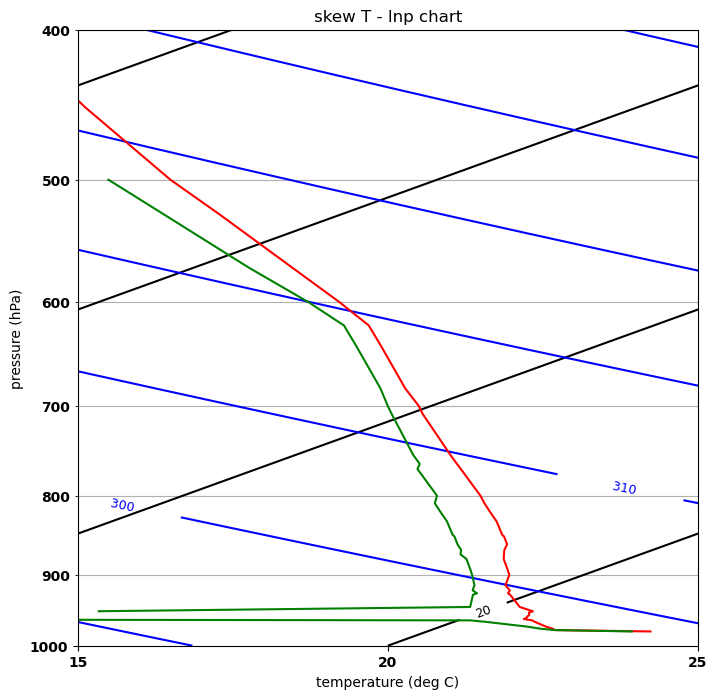

In [16]:
skew=30
skewtemp=convertTempToSkew(temp,press,skew)
skewdewpoint = convertTempToSkew(dewpoint,press,skew)
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax,skew=skew)
ax.plot(skewtemp,press,'r-')
ax.plot(skewdewpoint,press,'g-')
skewLimits = convertTempToSkew([15, 25], 1.e3, skew)
out=ax.set(xlim=skewLimits,ylim=(1000.,400.))

### If you have extra time

Repeat this using the [metpy skewT library](https://unidata.github.io/MetPy/latest/examples/plots/Simple_Sounding.html#sphx-glr-examples-plots-simple-sounding-py)

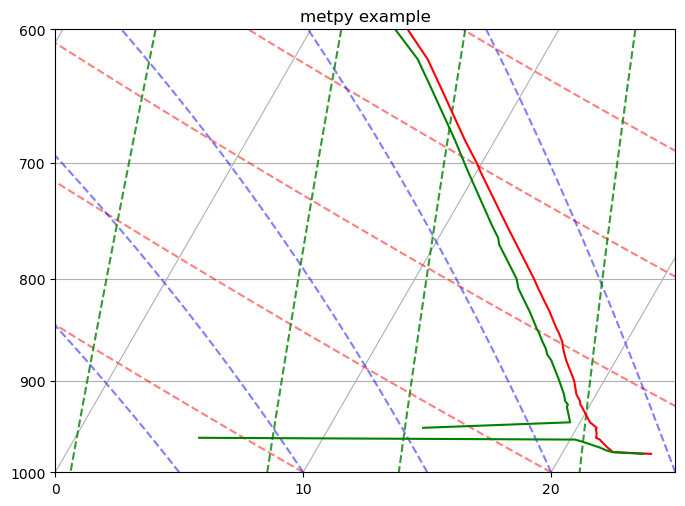

In [17]:
from metpy.plots import SkewT
from metpy.units import units
fig,ax =plt.subplots(1,1,figsize=(8,8))
fig.clf()
skew_plot = SkewT(fig)
skew_plot.ax.set_title("metpy example")
skew_plot.ax.set(xlim=(0,25),ylim=(1000,600))
theta = np.array([0,10,20,30,40,50,60]) + 273.15
#
# note metpy variables need units 
#
theta = theta*units("K")
skew_plot.plot_dry_adiabats(t0=theta)
skew_plot.plot_moist_adiabats()
skew_plot.plot_mixing_lines()
skew_plot.plot(press,temp,'r')
skew_plot.plot(press,dewpoint,'g');